In [1]:
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa as tsa
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import matplotlib.pyplot as plt
#!pip install arch
from arch import arch_model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

warnings.simplefilter('ignore')

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    test_stationarity(y)
        
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()

## 1 Приближение и прогнозирование с помощью GARCH временного ряда со статистикой пассажиров авиакомпании

In [3]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
series = airlines_passengers['Count']
airlines_passengers[:6]

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


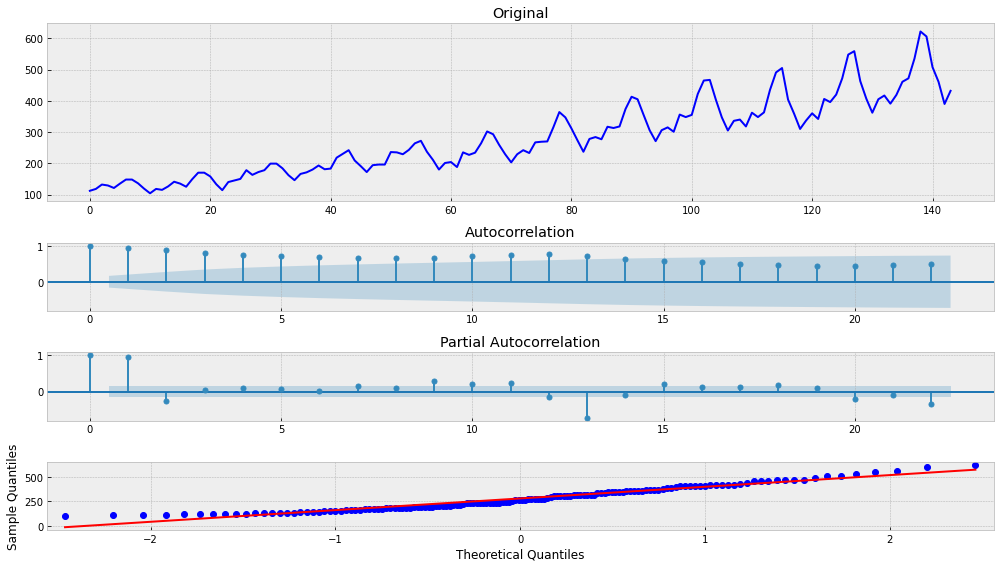

In [4]:
tsplot(series)

По результатам графиков наблюдаем линейную тенденцию у временного ряда, а так же сезонность размером в 12 месяцев. Так же данные ряда не распределены нормально.

Для модели GARCH требуется привести ряд к стационарному. Уберем тенденцию дисперсии с помощью преобразования Бокса-Кокса, тенденцию уберем с помощью дифференцирования первого порядка с лагом 1. А сезонность уберем с помощью дифференцирования с лагом 12.

Results of Dickey-Fuller Test:
Test Statistic                -1.630153e+01
p-value                        3.262620e-29
#Lags Used                     1.300000e+01
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


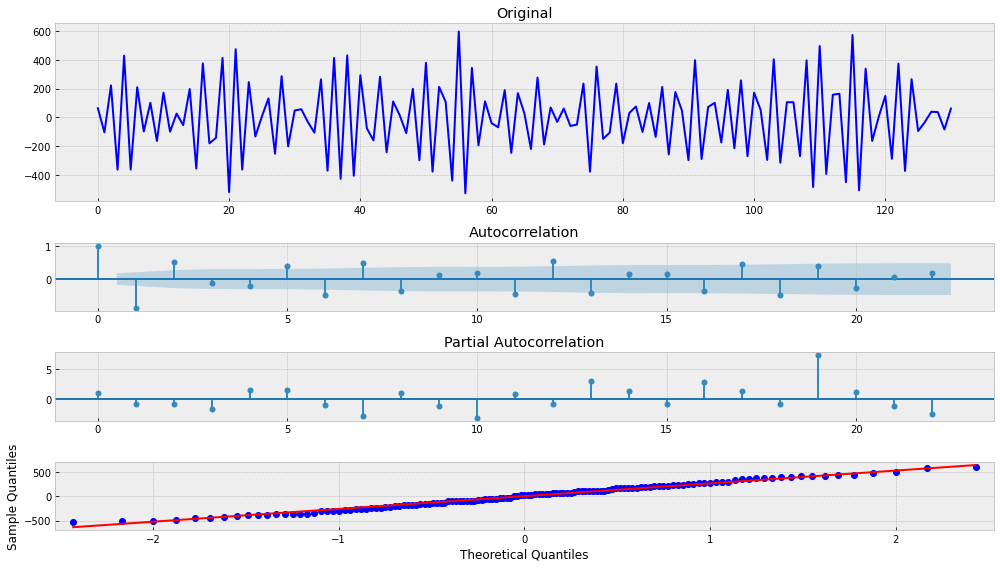

In [5]:
series_st = boxcox(series)[0]
series_st = np.diff(series_st, 12)
series_st = np.diff(series_st, 1)
series_st = pd.Series(series_st)
tsplot(series_st)

Найдем оптимальные параметры p и q с помощью модели ARIMA на основе анализа значения aic.

In [6]:
def get_best_params(series, range_p=5, range_d=5, range_q=5, seasons_len=None, print_info=True,
                   return_model=False):
    """ Поиск лучших параметров на основе модели ARIMA
    
    Параметры
    ---------
    series : pandas series
      Временной ряд
    range_p : int, (int, int)
      Диапазон значений p. Если целое число, то диапазон от 0 до range_p.
      Если кортеж (start, end), то от start до end
    range_d : int, (int, int)
      Диапазон значений d. Если целое число, то диапазон от 0 до range_d.
      Если кортеж (start, end), то от start до end
    range_q : int, (int, int)
      Диапазон значений q. Если целое число, то диапазон от 0 до range_q.
      Если кортеж (start, end), то от start до end
    seasons_len : int
      Длина сезона. Если указана, то используется модель SARIMA. Если None, то используется ARIMA
    print_info : bool
      Если True, то выводит на экран информацию о лучших параметрах
    return_model : bool
      Если True, то возвращается лучшая обученная модель
      
    Результат
    ---------
    p, d, q, best_model : (int, int, int, model)
      Лучшие значения p, d, q и лучшая модель. Лучшая обученная модель возвращается 
      только при return_model=True
    """
    
    best_aic = np.inf
    
    best_p = None
    best_d = None
    best_q = None
    best_model = None
    
    seasons_len = int(seasons_len) if seasons_len else None
    
    try:
        
        if isinstance(range_p, int) or isinstance(range_p, float):
            range_p = tuple([int(range_p+1)])
        if isinstance(range_d, int) or isinstance(range_d, float):
            range_d = tuple([int(range_d+1)])
        if isinstance(range_q, int) or isinstance(range_q, float):
            range_q = tuple([int(range_q+1)]) 

        if not isinstance(range_p, tuple):
            range_p = tuple(range_p)
        if not isinstance(range_d, tuple):
            range_d = tuple(range_d)
        if not isinstance(range_q, tuple):
            range_q = tuple(range_q)
            
    except Exception as error:
        print(f'Произошла ошибка конвертации параметров в кортеж: {error}')
        return (best_p, best_d, best_q, best_model) if return_model else (best_p, best_d, best_q)
    
    cicle_count = len(range(*range_p)) * len(range(*range_d)) * len(range(*range_q))

    warnings.simplefilter('ignore')
    with tqdm_notebook(total=cicle_count) as pbar:
        for p in range(*range_p):
            for d in range(*range_d):
                for q in range(*range_q):
                    if seasons_len:
                        model_params = {'order': (p,d,q), 'seasonal_order': (p,d,q,seasons_len)}
                    else:
                        model_params = {'order': (p,d,q)}
                    try:
                        model = tsa.arima.model.ARIMA(series, **model_params)
                        res = model.fit()
                    except:
                        pbar.update(1)
                        continue
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_p = p
                        best_d = d
                        best_q = q
                        best_model = res
                    pbar.update(1)             
                    
    print(f'Лучшие параметры: p={best_p}, d={best_d}, q={best_q}. AIC={best_aic}')
    
    return (best_p, best_d, best_q, best_model) if return_model else (best_p, best_d, best_q)

In [7]:
p, d, q, best_model = get_best_params(series_st, range_p=5, range_d=1, range_q=5, return_model=True)


Лучшие параметры: p=3, d=1, q=1. AIC=10.0


Посмотрим как выглядят остатки нашей обученной модели

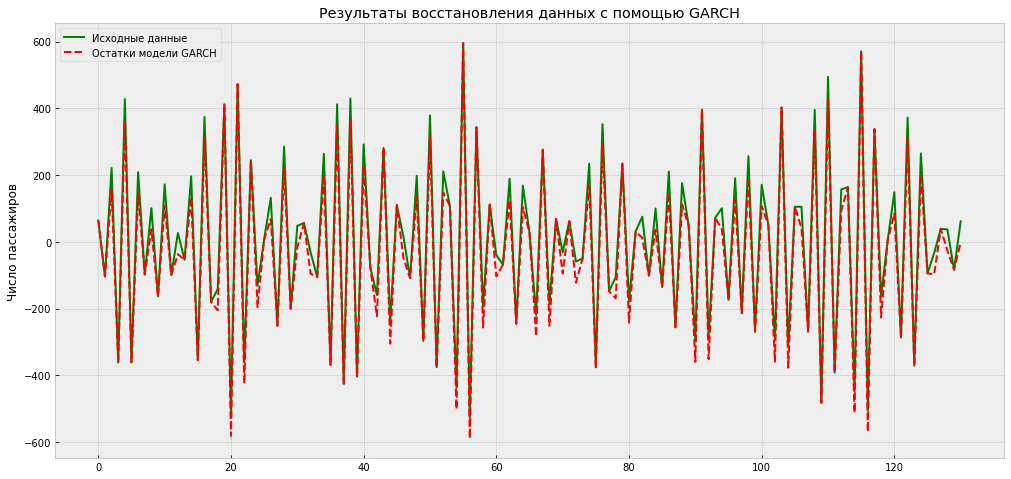

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(series_st, color='green', label='Исходные данные')
    plt.plot(best_model.resid, color='red', linestyle='--', label='Остатки модели GARCH')
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Результаты восстановления данных с помощью GARCH')
    plt.show()

Как видно из графика, модель GARCH смогла достаточно точно восстановить исходный временной ряд.

Теперь попробуем восстановить наши исходные данные с помощью предсказаний GARCH. Для этого будем обучать нашу модель на ограниченном количестве данных и предсказывать одно следующее значение.

Например, нам нужно восстановить с помощью модели 36 последних значений. А весь набор состоит из 144 значений. Обучим модель на 144-36=108 первых значений и получим предсказание для 109 значения. Потом обучим на 109 исходных значениях и получим предсказание для 110 значения. В итоге получим последовательный список предсказаний от 108 значения до 144.

In [9]:
def get_rolling_garch_predict(series, p, q, test_size=36):
    """ 
    Параметры
    ---------
    series : pandas series
      Временной ряд
    p : int
      Параметр p модели GARCH
    q : int
      Параметр q модели GARCH
    test_size : int
      Количество измерений последних данных, которые требуется восстановить с помощью GARCH
    """
    
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    predict = []
    
    for i in range(test_size):
        model = arch_model(series[:-test_size+i], p=p, q=q, o=0, 
                           vol='GARCH', dist='studentst').fit(disp='off')
        res = model.forecast(horizon=1, reindex=False)
        pred_val = np.sqrt(res.variance.values[-1][0])
        predict.append(pred_val)
        
    return predict

In [10]:
test_size = 24
predict = get_rolling_garch_predict(series_st, p=p, q=q, test_size=test_size)

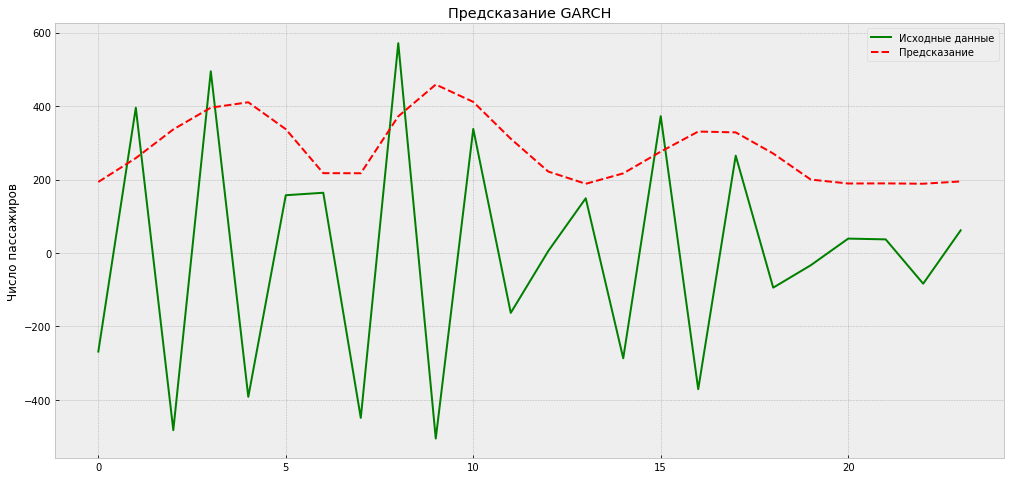

In [11]:
with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(np.arange(test_size), series_st[-test_size:], color='green', label='Исходные данные')
    plt.plot(predict, color='red', linestyle='--', label='Предсказание')
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Предсказание GARCH')
    plt.show()

## 2 Приближение и прогнозирование временного ряда со статистикой пассажиров авиакомпании с помощью полиномиальной регрессии 

Так как у нас временной ряд содержит сезонность по месяцу, то в качестве принаков можно сгенерировать значения синусов и косинусов по месяцам с помощью формул:

x_sin = sin( 2*pi*x / max(x) )  
x_cos = cos( 2*pi*x / max(x) )  

Здесь x - текущий номер месяца. Для нашей ситуации max(x) равен 12. Благодаря этим признакам расстояния для модели между 1 и 2, 12 и 1 будут одинаковыми.

Реализуем данные признаки.

In [12]:
def prepareData(data, lag_start=None, lag_end=None, test_size=0.15, period=False, degree=None):
    
    if lag_start == 0:
        raise ValueError('Начальный лаг не может быть равено 0')
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    if lag_end:
        lag_start = 1 if not lag_start else int(lag_start)
        for i in range(lag_start, lag_end):
            data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    data['Year'] = data.Month.apply(lambda x: int(str(x).split('-')[0]))
    data['Month'] = data.Month.apply(lambda x: int(str(x).split('-')[1]))
    if period:
        data['month_sin'] = data.Month.apply(lambda x: np.sin(2*np.pi*x / 12))
        data['month_cos'] = data.Month.apply(lambda x: np.cos(2*np.pi*x / 12))
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    if degree:
        polymome = PolynomialFeatures(degree=degree, interaction_only=True)
        X_train = polymome.fit_transform(X_train)
        X_test = polymome.transform(X_test)
    
    return X_train, X_test, y_train, y_test

Посмотрим как справится обычная линейна регрессия только в признаками в виде дня и месяца

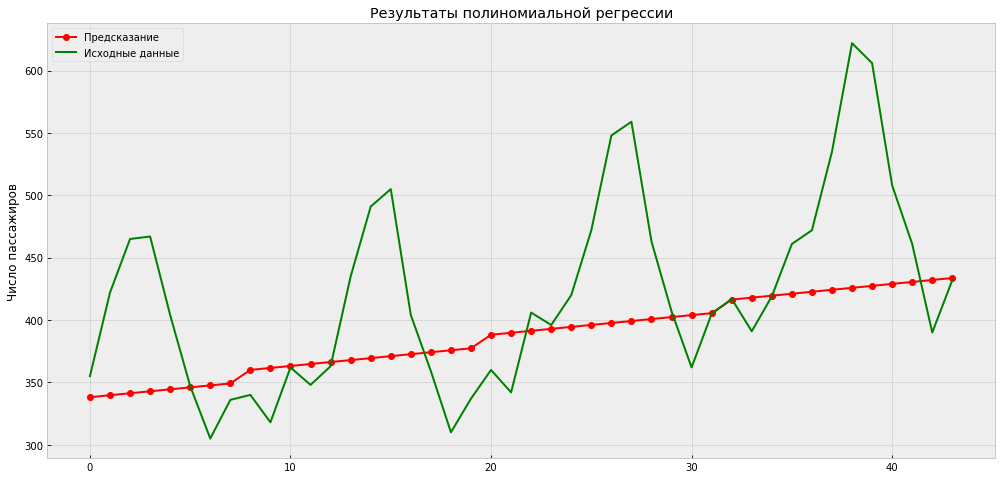

In [13]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, test_size=0.3, period=False)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(lr_predict, label='Предсказание', color='red', marker='o')
    plt.plot(np.arange(len(y_test)), y_test, label='Исходные данные', color='green',)
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Результаты полиномиальной регрессии')
    plt.show()

Ожидаем получили просто прямую линию, которая пытается уловить только тренд. Теперь попробуем ввести признаки периодичности через синус и косинус.

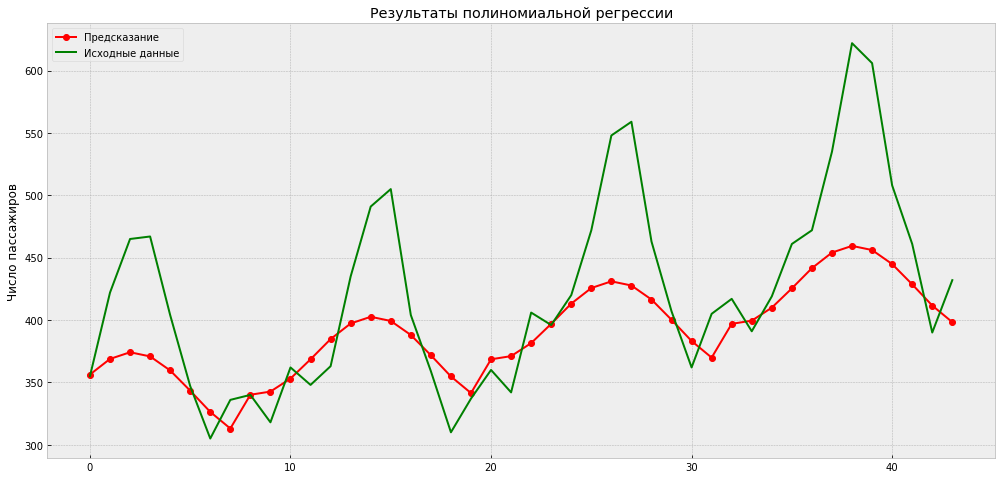

In [14]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, test_size=0.3, period=True)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(lr_predict, label='Предсказание', color='red', marker='o')
    plt.plot(np.arange(len(y_test)), y_test, label='Исходные данные', color='green',)
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Результаты полиномиальной регрессии')
    plt.show()

Теперь линейная регрессия стала улавливать периодичность и тренд, но с достаточно большой ошибкой. Попробуем обучить регрессию с помощью полиномиальных признаков степени 3.

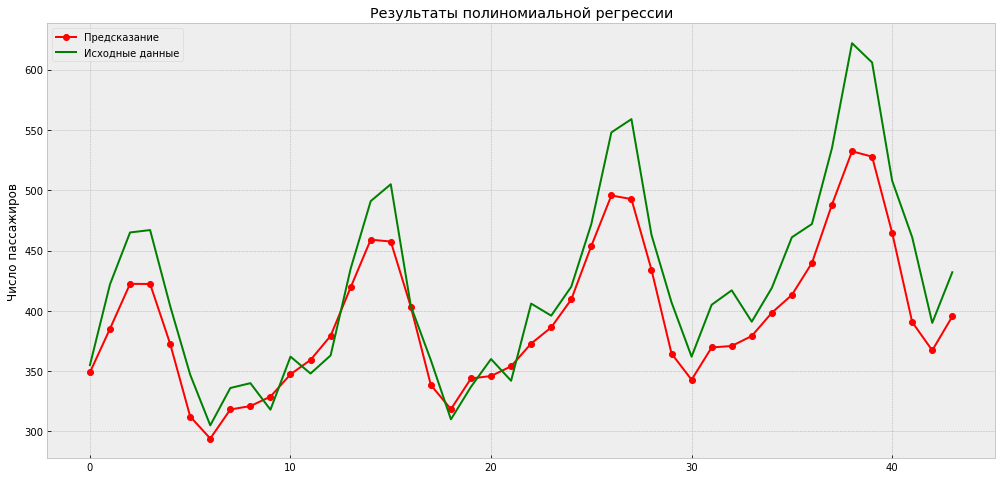

In [15]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, test_size=0.3, period=True, degree=3)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(lr_predict, label='Предсказание', color='red', marker='o')
    plt.plot(np.arange(len(y_test)), y_test, label='Исходные данные', color='green',)
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Результаты полиномиальной регрессии')
    plt.show()

Прогноз получился гораздо более точный, но тем не менее далек от идеала в пиках.
Попробуем использовать в качестве признаков только временные лаги размером сезонности от 1 до 12 

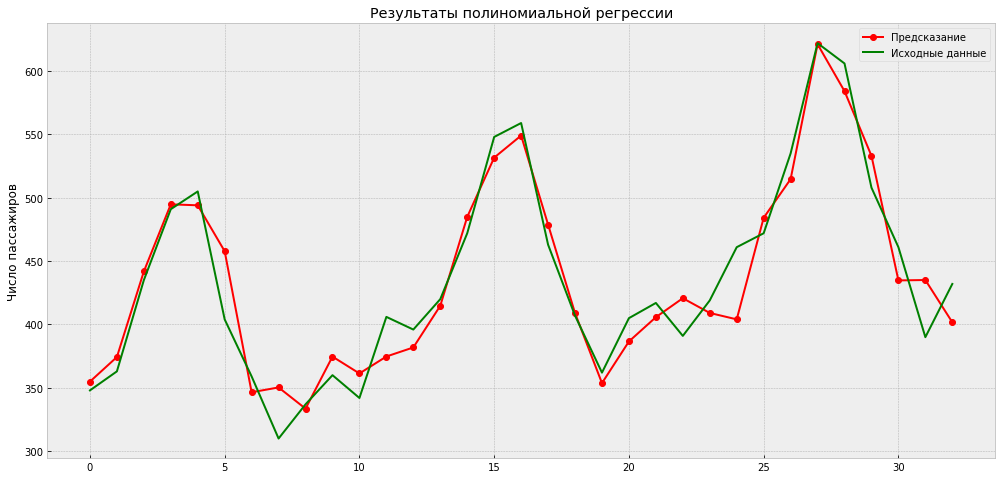

In [16]:
X_train, X_test, y_train, y_test = prepareData(airlines_passengers, lag_start=1, 
                                               lag_end=12, degree=0, period=True, test_size=0.3)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

with plt.style.context('bmh'):
    plt.figure(figsize=(17,8))
    plt.plot(lr_predict, label='Предсказание', color='red', marker='o')
    plt.plot(np.arange(len(y_test)), y_test, label='Исходные данные', color='green',)
    plt.legend()
    plt.ylabel('Число пассажиров')
    plt.title('Результаты полиномиальной регрессии')
    plt.show()

В результате бы получили достаточно хорошую предсказательную модель на основе линейной регрессии только с признаками на основе временных лагов